# Classificação de Infecções com imagens de radiografia do tórax

## Teste sem Data Augmentation e sem Transfer Learning

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn import metrics
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras


#To ensure reproducibility
#we set the random seed
seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

In [52]:
caminho_base = 'covid/'

for nome_pasta in os.listdir(caminho_base):
  caminho_completo = os.path.join(caminho_base, nome_pasta)
  if os.path.isdir(caminho_completo):
    print(nome_pasta)

covid
lungopacity
normal
viralpneumonia


In [3]:
#Auxiliary Function to plot images side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#Plot dataset samples
def plot_dataset(ds, lbls_name):
  N_SAMPLES = 10
  for i in range(5):
    for x,y in ds.take(1):

      x = x.numpy()
      x = np.squeeze(x)
      y = y.numpy()
      plot_sidebsyide(x[:N_SAMPLES],
                      y[:N_SAMPLES],'gray')

#Plot a training history
def plot_history(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [55]:
for names in ['covid','lungopacity','normal','viralpneumonia']:

  print("Names: ")
  # Directory containing the original images
  original_dir = f'covid/{names}'


  # Desired number of augmented images (total images after augmentation should be 200)
  target_num_images = 200

  # Create an ImageDataGenerator for data augmentation
  datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest'
  )

  # List original images in the directory
  original_images = os.listdir(original_dir)
  print(original_images)
  # Continue until we have 200 images

  while len(os.listdir(original_dir)) < target_num_images:
      # Choose a random image from the original set
      img_name = random.choice(original_images)
      img_path = os.path.join(original_dir, img_name)

      # Load the image and convert it to a Numpy array
      img = load_img(img_path)
      x = img_to_array(img)
      x = x.reshape((1,) + x.shape)
      print("Names: ", names, len(os.listdir(original_dir)))
      # Generate augmented images and save them
      i = 0
      for batch in datagen.flow(x, batch_size=1):
          augmented_image = array_to_img(batch[0])
          augmented_image.save(os.path.join(original_dir, f'augmented_{i}_{img_name}'))
          i += 1
          if i >= 10:  # Adjust the number of augmented images per original image as needed
              break



Names: 
['covid1.png', 'covid10.png', 'covid100.png', 'covid1000.png', 'covid1001.png', 'covid1002.png', 'covid1003.png', 'covid1004.png', 'covid1005.png', 'covid1006.png', 'covid1007.png', 'covid1008.png', 'covid1009.png', 'covid101.png', 'covid1010.png', 'covid1011.png', 'covid1012.png', 'covid1013.png', 'covid1014.png', 'covid1015.png', 'covid1016.png', 'covid1017.png', 'covid1018.png', 'covid1019.png', 'covid102.png', 'covid1020.png', 'covid1021.png', 'covid1022.png', 'covid1023.png', 'covid1024.png', 'covid1025.png', 'covid1026.png', 'covid1027.png', 'covid1028.png', 'covid1029.png', 'covid103.png', 'covid1030.png', 'covid1031.png', 'covid1032.png', 'covid1033.png', 'covid1034.png', 'covid1035.png', 'covid1036.png', 'covid1037.png', 'covid1038.png', 'covid1039.png', 'covid104.png', 'covid1040.png', 'covid1041.png', 'covid1042.png', 'covid1043.png', 'covid1044.png', 'covid1045.png', 'covid1046.png', 'covid1047.png', 'covid1048.png', 'covid1049.png', 'covid105.png', 'covid1050.png',

In [69]:
import shutil
from sklearn.model_selection import train_test_split

# Definir caminhos das pastas 
base_dir = 'covid/'
train_dir = 'dataset_split/train/'
test_dir = 'dataset_split/test/'
classes = ['covid', 'lungopacity', 'normal', 'viralpneumonia']

# Criar as pastas de destino, se não existirem
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)
    
    # Dividir em treino, teste e validação
    train_imgs, test_imgs = train_test_split(images, test_size=0.3, random_state=seed_number)

    # Criar pastas de classe para treino, teste
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
    # Mover as imagens para as respectivas pastas
    for img in train_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_dir, class_name, img))



In [2]:
data_dir = 'dataset_split/train/'
batch_size_ = 32
input_shape_ = (128,128,3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

Found 14814 files belonging to 4 classes.
Using 11852 files for training.
Found 14814 files belonging to 4 classes.
Using 2962 files for validation.


['covid', 'lungopacity', 'normal', 'viralpneumonia']
tf.Tensor([2 1 2 2 0 2 2 2 2 2 2 2 1 2 1 1 1 1 2 2 1 2 2 2 2 2 1 1 2 1 0 0], shape=(32,), dtype=int32)


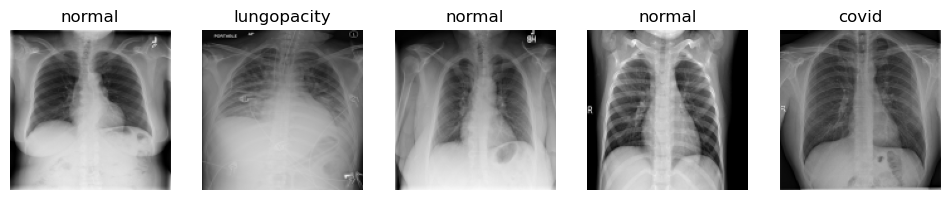

tf.Tensor([1 0 2 2 0 3 3 2 2 2 1 2 1 2 2 0 2 0 2 2 2 0 1 2 2 1 1 1 2 0 1 2], shape=(32,), dtype=int32)


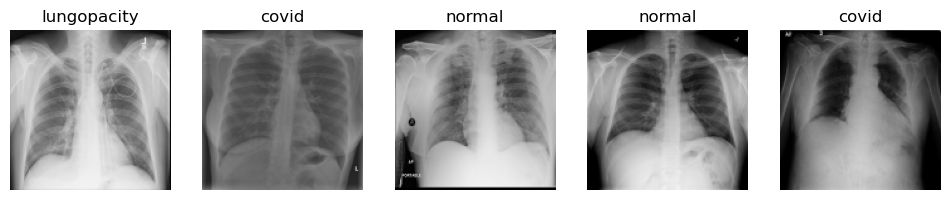

tf.Tensor([2 1 2 2 3 2 1 0 2 0 0 3 0 2 2 0 1 2 1 2 0 2 3 0 2 2 2 1 2 2 1 2], shape=(32,), dtype=int32)


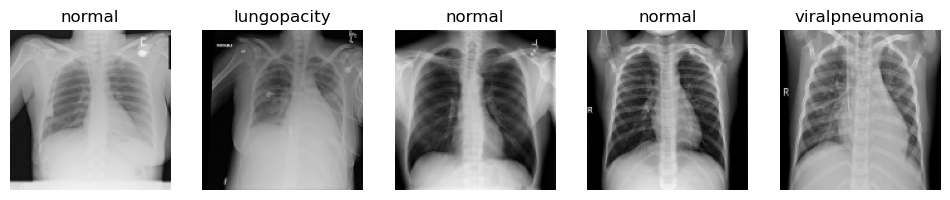

tf.Tensor([2 2 2 2 2 2 3 2 2 0 1 2 2 0 2 1 2 1 2 0 2 1 2 2 2 1 2 0 1 0 1 0], shape=(32,), dtype=int32)


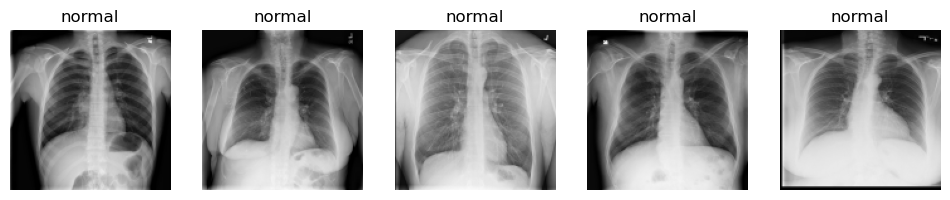

tf.Tensor([2 1 2 1 2 0 2 1 1 2 2 2 2 1 2 1 2 2 1 1 1 2 2 2 3 0 2 1 0 1 2 2], shape=(32,), dtype=int32)


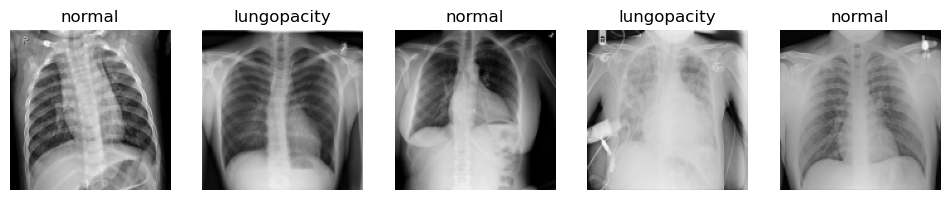

tf.Tensor([2 2 1 2 1 1 0 2 2 1 2 2 2 1 2 2 2 0 1 2 2 0 0 0 2 2 1 1 1 2 1 3], shape=(32,), dtype=int32)


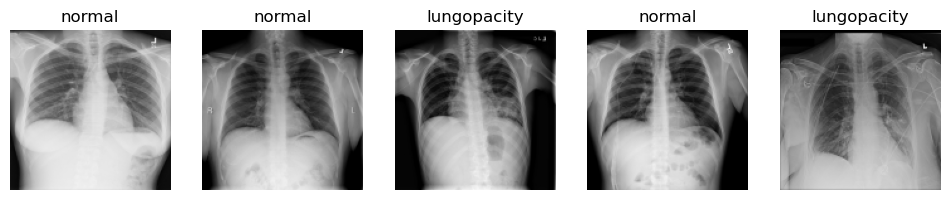

tf.Tensor([1 0 2 0 2 2 2 2 3 2 2 2 1 0 2 1 0 3 2 0 2 2 2 1 2 2 2 2 2 1 3 0], shape=(32,), dtype=int32)


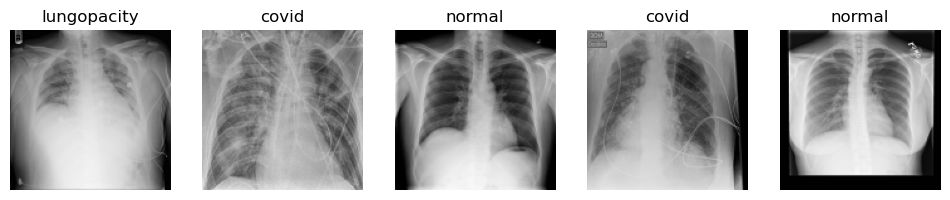

tf.Tensor([2 1 1 3 2 2 2 0 1 2 2 2 3 2 2 0 0 1 1 2 1 0 1 1 3 2 1 2 2 2 2 2], shape=(32,), dtype=int32)


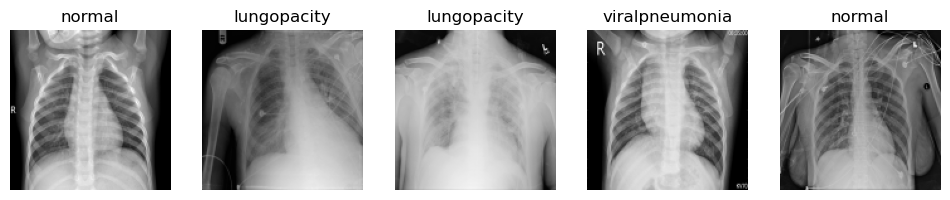

tf.Tensor([2 1 1 0 0 0 2 2 1 1 1 1 1 2 2 0 2 1 2 1 2 2 1 2 2 2 0 0 2 2 2 2], shape=(32,), dtype=int32)


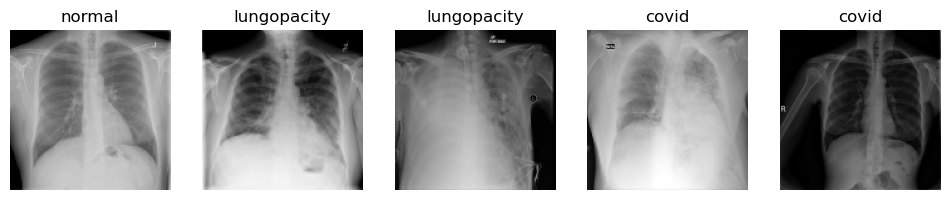

tf.Tensor([3 2 1 2 1 2 2 1 2 1 1 1 1 2 1 2 0 2 2 0 2 2 3 0 2 2 2 3 2 1 1 1], shape=(32,), dtype=int32)


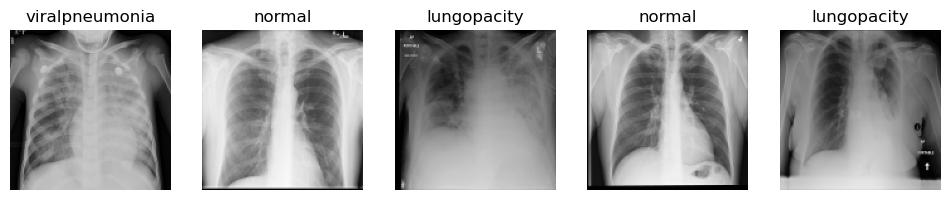

In [4]:

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)
for img,lbl in train_ds.take(10):

  titles = []
  print(lbl)
  for i in lbl:
    titles.append(class_names[i])

  plot_sidebyside(img[:5]/255.,titles[:5])

In [5]:

y_train = []
x_train = []

for img, labels in train_ds:
    y_train.extend(labels.numpy())
    x_train.extend(img)

y_train = np.array(y_train)
x_train = np.array(x_train)

In [6]:
ret = np.unique(y_train,return_counts=True)
print(class_names)
print(ret)
     

['covid' 'lungopacity' 'normal' 'viralpneumonia']
(array([0, 1, 2, 3]), array([2027, 3371, 5698,  756], dtype=int64))


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape_))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])



In [91]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'bestmodel_teste1.weights.h5',
    save_best_only=True,         
    save_weights_only=True,
    monitor='val_acc' ,              
    mode='max',
    verbose=1
)

epochs_ = 50
history = model.fit(train_ds, batch_size=32, epochs=50, validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - acc: 0.5107 - loss: 1.7595
Epoch 1: val_acc improved from -inf to 0.64146, saving model to bestmodel_teste1.weights.h5
371/371 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - acc: 0.5108 - loss: 1.7579 - val_acc: 0.6415 - val_loss: 0.8648
Epoch 2/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - acc: 0.6067 - loss: 0.8833
Epoch 2: val_acc improved from 0.64146 to 0.66172, saving model to bestmodel_teste1.weights.h5
371/371 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - acc: 0.6067 - loss: 0.8832 - val_acc: 0.6617 - val_loss: 0.8056
Epoch 3/50
370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - acc: 0.6622 - loss: 0.7823
Epoch 3: val_acc improved from 0.66172 to 0.73903, saving model to bestmodel_teste1.weights.h5
371/371 ━━━━━━━━━━━━━━━━━━━━ 45s 121ms/step - acc: 0.6623 - loss: 0.7822 - val_acc: 0.7390 - val_loss: 0.6881
Epoch 4/50
370/371 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - acc: 0.7033 - loss: 0.7202
Epoch 4: val_acc improved from 0.73903 to 0.76840, savin

In [32]:
batch_size_ = 32
input_shape_ = (128,128,3)

test_ds = tf.keras.utils.image_dataset_from_directory(
  f'dataset_split/test/',
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

Found 6351 files belonging to 4 classes.


In [14]:
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf

# Carrega os pesos e avalia o modelo

model.load_weights('bestmodel_teste1.weights.h5')

# Previsões do modelo no conjunto de teste
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calcula as métricas de acurácia, precisão, recall e F1-score
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))


c:\Users\gugus\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


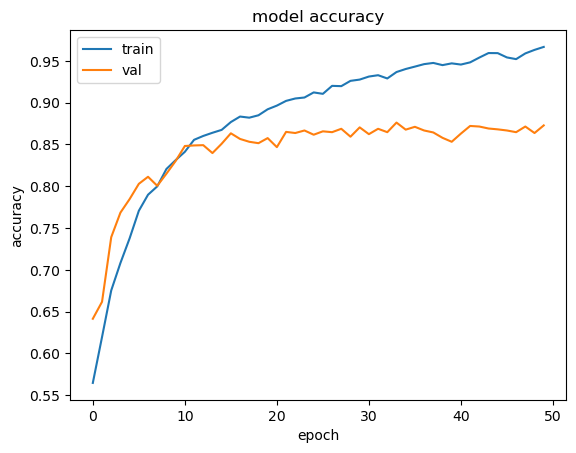

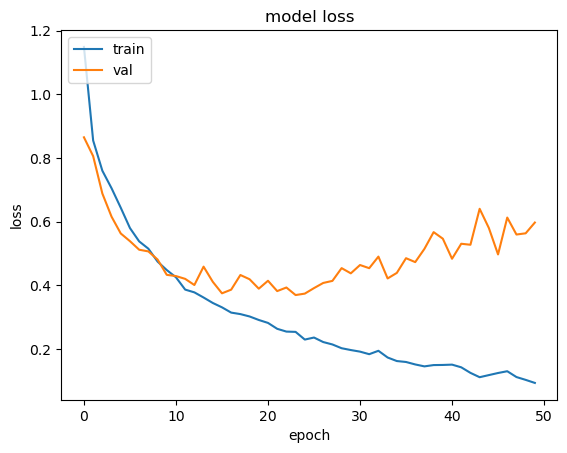

In [96]:
plot_history(history)


## Teste com Data Augmentation

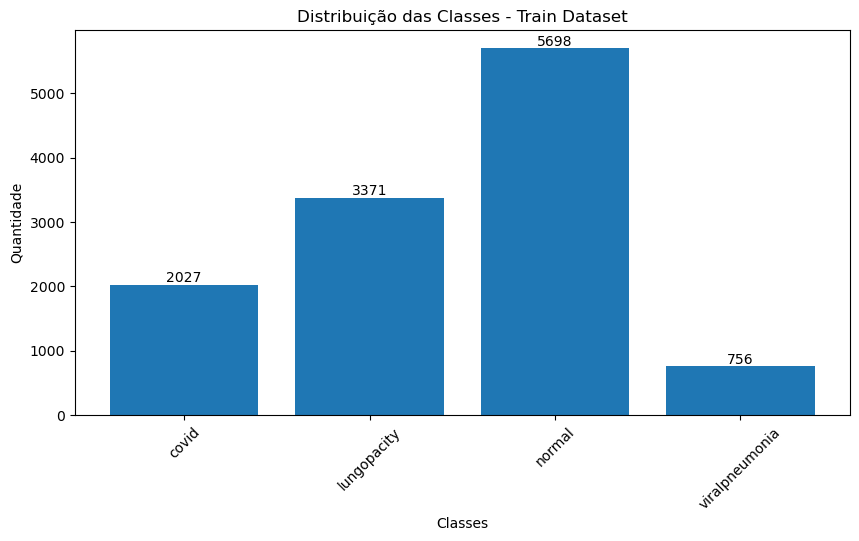

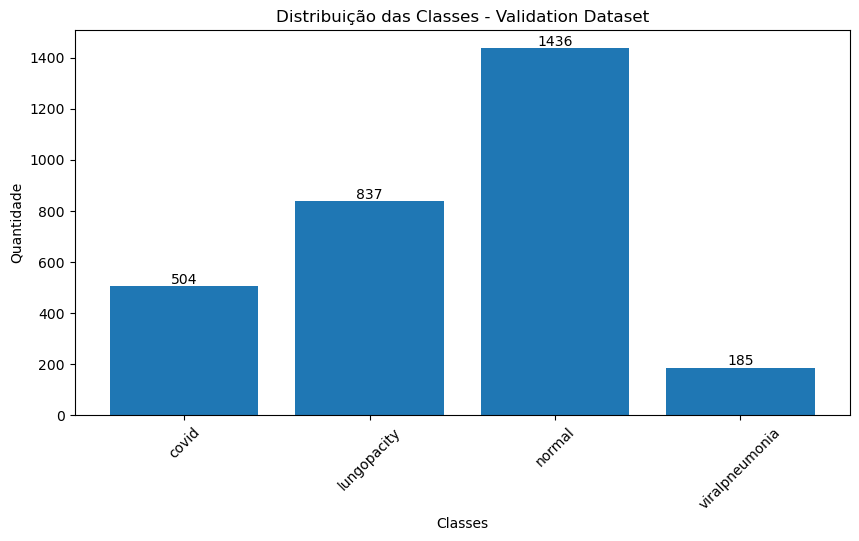

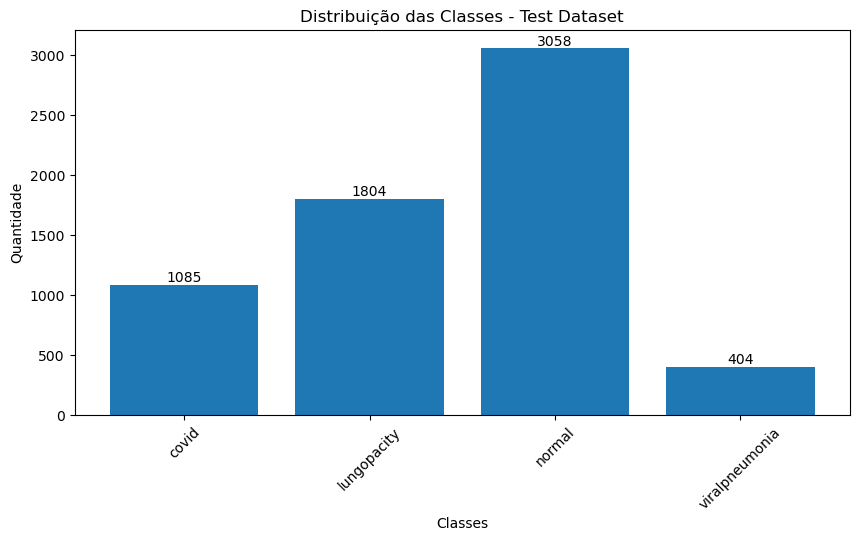

In [48]:
import matplotlib.pyplot as plt

def plot_class_distribution(dataset, title):
    class_names = dataset.class_names
    class_counts = [0] * len(class_names)

    for images, labels in dataset:
        for label in labels.numpy():
            class_counts[label] += 1

    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45)

    # Adicionando rótulos acima das barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.show()

# Plotando a distribuição das classes
plot_class_distribution(train_ds, 'Distribuição das Classes - Train Dataset')
plot_class_distribution(val_ds, 'Distribuição das Classes - Validation Dataset')
plot_class_distribution(test_ds, 'Distribuição das Classes - Test Dataset')



### Data Augmentation no dados de treino

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal", input_shape=(input_shape_[0], input_shape_[1], 3)),
        tf.keras.layers.RandomRotation(0.15),
        tf.keras.layers.RandomZoom(0.3),
        tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ]
)


Imagens aumentadas para 'covid': 1000
Imagens aumentadas para 'viral pneumonia': 1000


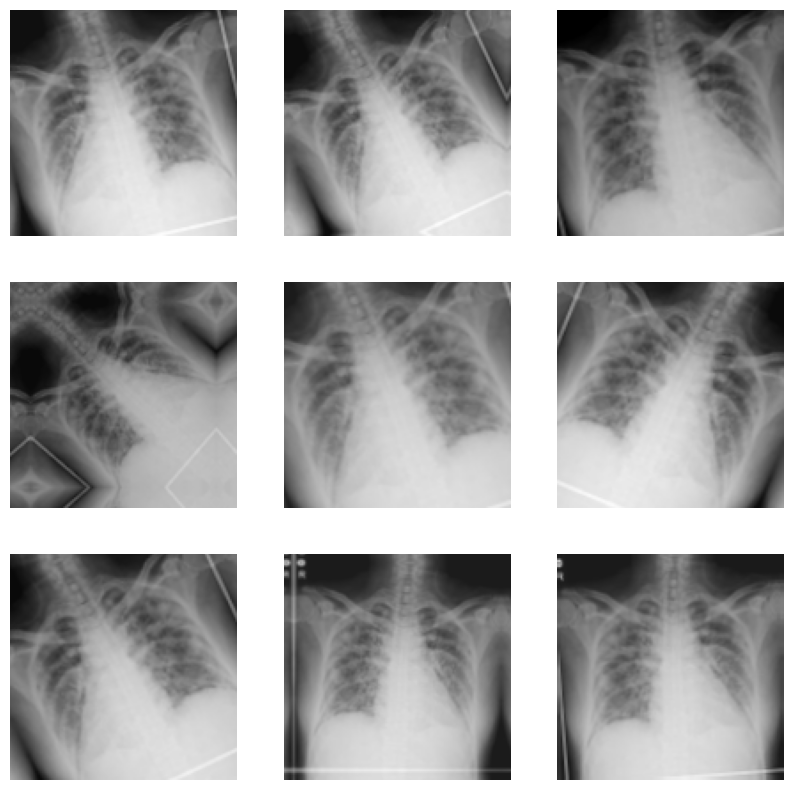

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal", input_shape=(input_shape_[0], input_shape_[1], 3)),
        tf.keras.layers.RandomRotation(0.15),
        tf.keras.layers.RandomZoom(0.3),
        tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ]
)

target_classes = [0, 3]
augmentation_target_count = 1000  

# Contadores para rastrear o número de imagens aumentadas
augmented_count = {0: 0, 3: 0}

# Listas para armazenar as imagens e labels aumentadas
augmented_images = []
augmented_labels = []

# Loop para aplicar data augmentation nas classes 
for images, labels in train_ds:
    for i in range(len(labels)):
        label = labels[i].numpy()
        # Continua aplicando data augmentation até atingir o número desejado para cada classe
        while label in target_classes and augmented_count[label] < augmentation_target_count:
            # Aplica data augmentation
            augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
            augmented_images.append(augmented_image[0])
            augmented_labels.append(label)
            augmented_count[label] += 1

            # Se já tiver atingido 1000 imagens para ambas as classes, saia do loop
            if all(count >= augmentation_target_count for count in augmented_count.values()):
                break
        if all(count >= augmentation_target_count for count in augmented_count.values()):
            break
    if all(count >= augmentation_target_count for count in augmented_count.values()):
        break

# Verifica se foram geradas exatamente 1000 imagens para cada classe
print(f"Imagens aumentadas para 'covid': {augmented_count[0]}")
print(f"Imagens aumentadas para 'viral pneumonia': {augmented_count[3]}")

# Exibe algumas amostras de data augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()


In [29]:
import tensorflow as tf

augmented_images_tensor = tf.convert_to_tensor(augmented_images, dtype=tf.float32)
augmented_labels_tensor = tf.convert_to_tensor(augmented_labels, dtype=tf.int32)

augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_images_tensor, augmented_labels_tensor))

original_images = []
original_labels = []

for images, labels in train_ds:
    original_images.append(images)
    original_labels.append(labels)

original_images_tensor = tf.concat(original_images, axis=0)
original_labels_tensor = tf.concat(original_labels, axis=0)

train_ds = tf.data.Dataset.from_tensor_slices((original_images_tensor, original_labels_tensor))

train_ds = train_ds.concatenate(augmented_dataset)

train_ds = train_ds.shuffle(buffer_size=1000)

train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [30]:
print("Dimensões de original treino:", original_images_tensor.shape)
print("Dimensões de augmented treino:", augmented_images_tensor.shape)
print("Dimensões de original label treino:", original_labels_tensor.shape)
print("Dimensões de augmented label treino:", augmented_labels_tensor.shape)

Dimensões de original treino: (11852, 128, 128, 3)
Dimensões de augmented treino: (2000, 128, 128, 3)
Dimensões de original label treino: (11852,)
Dimensões de augmented label treino: (2000,)


### Data Augmentation nos dados de Validação

Imagens aumentadas para 'covid': 1000
Imagens aumentadas para 'viral pneumonia': 1000


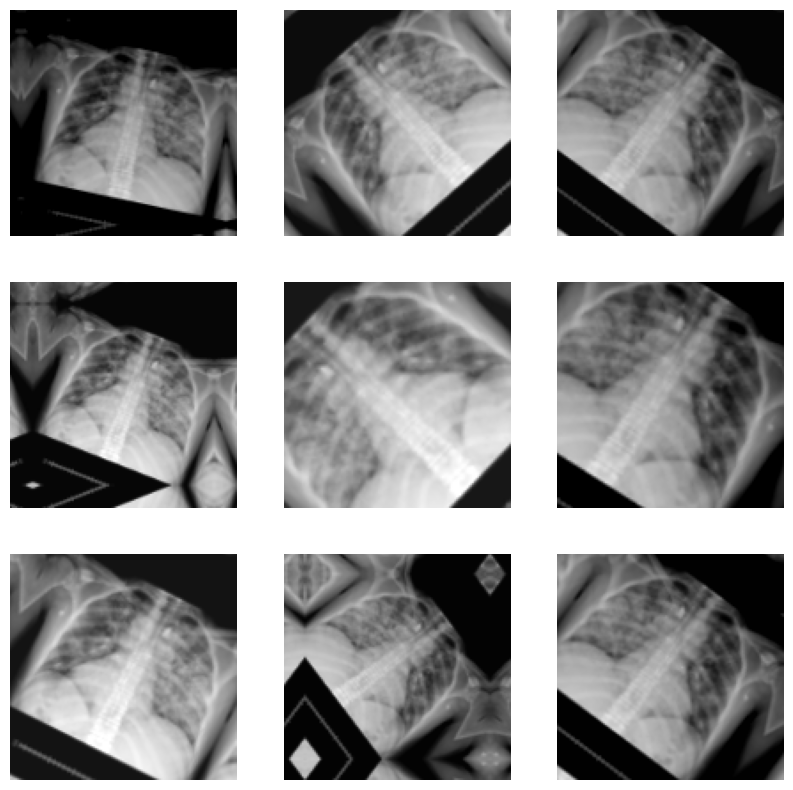

In [34]:
# Alvo de aumento de dados
target_classes = [0, 3]  # Supondo que 0 é "covid" e 3 é "viral pneumonia"
augmentation_target_count = 1000  # Número desejado de amostras aumentadas por classe

# Contadores para rastrear o número de imagens aumentadas
augmented_count = {0: 0, 3: 0}

# Listas para armazenar as imagens e labels aumentadas
augmented_images = []
augmented_labels = []

# Loop para aplicar data augmentation nas classes minoritárias
for images, labels in val_ds:
    for i in range(len(labels)):
        label = labels[i].numpy()
        # Continua aplicando data augmentation até atingir o número desejado para cada classe
        while label in target_classes and augmented_count[label] < augmentation_target_count:
            # Aplica data augmentation
            augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
            augmented_images.append(augmented_image[0])
            augmented_labels.append(label)
            augmented_count[label] += 1

            # Se já tiver atingido 1000 imagens para ambas as classes, saia do loop
            if all(count >= augmentation_target_count for count in augmented_count.values()):
                break
        if all(count >= augmentation_target_count for count in augmented_count.values()):
            break
    if all(count >= augmentation_target_count for count in augmented_count.values()):
        break

# Verifica se foram geradas exatamente 1000 imagens para cada classe
print(f"Imagens aumentadas para 'covid': {augmented_count[0]}")
print(f"Imagens aumentadas para 'viral pneumonia': {augmented_count[3]}")

# Exibe algumas amostras de data augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

In [35]:
import tensorflow as tf

augmented_images_tensor = tf.convert_to_tensor(augmented_images, dtype=tf.float32)
augmented_labels_tensor = tf.convert_to_tensor(augmented_labels, dtype=tf.int32)

augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_images_tensor, augmented_labels_tensor))

original_images = []
original_labels = []

for images, labels in val_ds:
    original_images.append(images)
    original_labels.append(labels)

original_images_tensor = tf.concat(original_images, axis=0)
original_labels_tensor = tf.concat(original_labels, axis=0)

val_ds = tf.data.Dataset.from_tensor_slices((original_images_tensor, original_labels_tensor))

val_ds = val_ds.concatenate(augmented_dataset)

val_ds = val_ds.shuffle(buffer_size=1000)

val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [36]:
print("Dimensões de original val:", original_images_tensor.shape)
print("Dimensões de augmented val:", augmented_images_tensor.shape)
print("Dimensões de original label val:", original_labels_tensor.shape)
print("Dimensões de augmented label val:", augmented_labels_tensor.shape)

Dimensões de original val: (2962, 128, 128, 3)
Dimensões de augmented val: (2000, 128, 128, 3)
Dimensões de original label val: (2962,)
Dimensões de augmented label val: (2000,)


In [46]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestmodel_teste2.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    verbose=1
)

# Compile e treine o modelo
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - acc: 0.4949 - loss: 1.4834
Epoch 1: val_acc improved from -inf to 0.40689, saving model to bestmodel_teste2.weights.h5
433/433 ━━━━━━━━━━━━━━━━━━━━ 168s 374ms/step - acc: 0.4951 - loss: 1.4825 - val_acc: 0.4069 - val_loss: 1.4928
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - acc: 0.5783 - loss: 0.9615
Epoch 2: val_acc improved from 0.40689 to 0.44740, saving model to bestmodel_teste2.weights.h5
433/433 ━━━━━━━━━━━━━━━━━━━━ 158s 364ms/step - acc: 0.5784 - loss: 0.9612 - val_acc: 0.4474 - val_loss: 1.4287
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - acc: 0.6530 - loss: 0.8552
Epoch 3: val_acc improved from 0.44740 to 0.57437, saving model to bestmodel_teste2.weights.h5
433/433 ━━━━━━━━━━━━━━━━━━━━ 161s 372ms/step - acc: 0.6532 - loss: 0.8549 - val_acc: 0.5744 - val_loss: 1.1481
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - acc: 0.7135 - loss: 0.7138
Epoch 4: val_acc did not improve from 0.57437
433/433

In [33]:
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf

# Carrega os pesos e avalia o modelo
model.load_weights('bestmodel_teste2.weights.h5')

# Previsões do modelo no conjunto de teste
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    
class_names = ['covid', 'lungopacity', 'normal', 'viralpneumonia']



# Calcula as métricas de acurácia, precisão, recall e F1-score
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


c:\Users\gugus\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


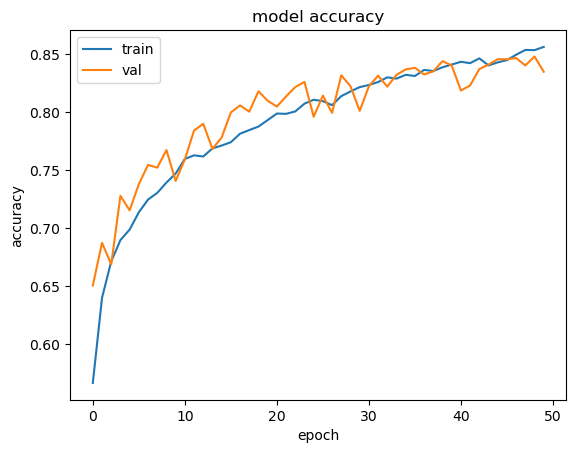

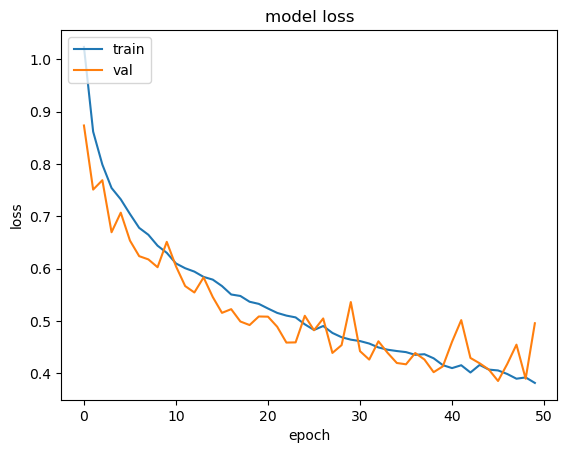

In [37]:
plot_history(history)

## Teste com Transfer Learning

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.models import Sequential

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128,3))

vgg_conv.trainable = False

model = Sequential()
model.add(vgg_conv)
model.add(Flatten()) #GlobalAvgPooling()
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])


In [7]:
data_dir = 'dataset_split/train/'
batch_size_ = 32
input_shape_ = (128,128,3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

test_ds = tf.keras.utils.image_dataset_from_directory(
  f'dataset_split/test/',
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)


Found 14814 files belonging to 4 classes.
Using 11852 files for training.
Found 14814 files belonging to 4 classes.
Using 2962 files for validation.
Found 6351 files belonging to 4 classes.


In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'bestmodel_teste3.weights.h5',
    save_best_only=True,         
    save_weights_only=True,
    monitor='val_acc' ,              
    mode='max',
    verbose=1
)

epochs_ = 50
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
history = model.fit(train_ds, batch_size=32, epochs=50, validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.7221 - loss: 10.3773
Epoch 1: val_acc improved from -inf to 0.87407, saving model to bestmodel_teste3.weights.h5
371/371 ━━━━━━━━━━━━━━━━━━━━ 1160s 3s/step - acc: 0.7223 - loss: 10.3567 - val_acc: 0.8741 - val_loss: 0.3642
Epoch 2/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.8818 - loss: 0.3777
Epoch 2: val_acc improved from 0.87407 to 0.89298, saving model to bestmodel_teste3.weights.h5
371/371 ━━━━━━━━━━━━━━━━━━━━ 1063s 3s/step - acc: 0.8818 - loss: 0.3776 - val_acc: 0.8930 - val_loss: 0.2879
Epoch 3/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9135 - loss: 0.2550
Epoch 3: val_acc did not improve from 0.89298
371/371 ━━━━━━━━━━━━━━━━━━━━ 960s 3s/step - acc: 0.9135 - loss: 0.2550 - val_acc: 0.8920 - val_loss: 0.3503
Epoch 4/50
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.9323 - loss: 0.2013
Epoch 4: val_acc did not improve from 0.89298
371/371 ━━━━━━━━━━━━━━━━━━━━ 960s 3s/step - acc: 0.9323 - loss: 0.2012 - 

In [11]:
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf

# Carrega os pesos e avalia o modelo
model.build(input_shape=(None, 128, 128, 3))

model.load_weights('bestmodel_teste3.weights.h5')

# Previsões do modelo no conjunto de teste
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calcula as métricas de acurácia, precisão, recall e F1-score
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))


c:\Users\gugus\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━